# C2M3: Peer Reviewed Assignment

### Outline:
The objectives for this assignment:

1. Motivate the use of two-way ANOVA through real data analysis examples.

2. Interpret the two-way ANOVA model, with and without interaction terms.

3. Construct and interpret interaction plots to visually assess the importance of an interaction term.

4. Conduct hypothesis tests to decide whether a two-way ANOVA interaction term is statistically significant.

5. Use the two-way ANOVA and ANCOVA models to answer research questions using real data.


General tips:

1. Read the questions carefully to understand what is being asked.
2. This work will be reviewed by another human, so make sure that you are clear and concise in what your explanations and answers.

In [8]:
# Load Required Packages
library(tidyverse)
library(ggplot2) # a package for nice plots!
library(dplyr)
library(emmeans)

# Problem 1: e-reader data

In this assignment, we learn to answer our two-way ANOVA research questions through the analysis of real data. We will use the ereader data. The study that generated these data can be found here: [P.-C. Chang, S.-Y. Chou, K.-K. Shieh (2013). "Reading Performance and Visual Fatigue When Using Electronic Displays in Long-Duration Reading Tasks Under Various Lighting Conditions," Displays, Vol. 34,
pp. 208-214.](http://users.stat.ufl.edu/~winner/data/ereader1.txt)) 

Electronic paper display devices, such as the Amazon Kindle have changed the way that people read. But has it changed for the better? In a 2013 study titled "Reading Performance and Visual Fatigue When Using Electronic Displays in Long-Duration Reading Tasks Under Various Lighting Conditions", researchers set out to ask whether reading speed (a continuous variable) differed across different electronic paper displays. In addition, they were also interested in whether different lighting conditions impacted reading speed. As such, this experiment had one response with two different factors:

1. Device type: three different types.
    1. Sony PRS-700 with a 6-in. display, $800 \times 600$ resolution; 
    2. Amazon Kindle DX with a 9.7-in. display, $1200 \times 824$ resolution; and 
    3. iRex 1000S with a 10.2-in. display, $1024 \times 1280$ resolution.


2. Lighting Condition: four different conditions (200Lx,500Lx, 1000Lx, 1500Lx), Lx = lux, one lumen per square meter


3. Reading Time: measured in seconds.

With these data, we might ask the following **research questions**:

1. Are the effects of device type significant? That is, is there evidence that suggests that individuals read at different speeds based on the device that they are using?


2. Are the effects of lighting conditions significant? That is, is there evidence that suggests that individuals read at different speeds based on the reading lighting conditions?


3. Do device type and lighting conditions *interact*? For example, Suppose that, on average, people can read for longer on device A than on device B, in low light. Is that trend the same in medium light, or bright light? If not, for example, if B is better than A in bright light, then type and lighting interact.

Through this entire analysis, let's set $\alpha = 0.05$. 

**First, let's read in the data, and store the appropriate variables as factors.**

In [2]:
# Load the data
read = read.csv("ereader.txt", sep="\t")

names(read) = c("device", "light", "time")
read$device = as_factor(read$device)
read$light = as.factor(read$light)
read$light = recode(read$light, "1" = "200Lx", "2" = "500Lx", "3" = "1000Lx", "4" = "1500Lx") 

summary(read)

 device    light         time       
 1:19   200Lx :14   Min.   : 543.8  
 2:20   500Lx :15   1st Qu.: 861.4  
 3:20   1000Lx:15   Median :1105.4  
        1500Lx:15   Mean   :1090.2  
                    3rd Qu.:1300.0  
                    Max.   :1797.2  

**1.(a) Construct interaction plots, and visually assess and comment on whether interactions are present.**

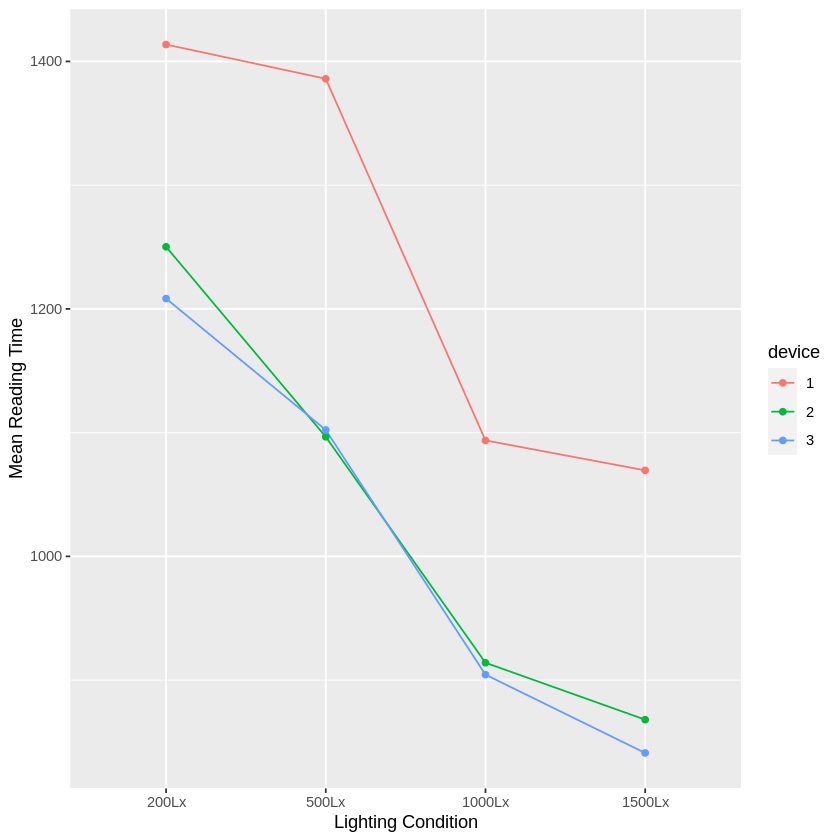

In [13]:
# # Your Code Here


# Calculate the mean for each combination of device and light
mean_data <- read %>%
  group_by(device, light) %>%
  summarize(mean_time = mean(time))

# Create the plot
ggplot(mean_data, aes(x = light, y = mean_time, color = device, group = device)) +
  geom_line() +
  geom_point() +
  xlab("Lighting Condition") +
  ylab("Mean Reading Time")


Tthe lines representing different devices are roughly parallel to each other across all lighting conditions, which suggests the absence of a significant interaction between device type and lighting conditions. This would indicate that the effect of device type on reading time is consistent regardless of the lighting conditions.

**1.(b) Now, let's formally test for an interaction. Fit a model with an interaction, and one without, and conduct an F-test. State the appropriate decision for the test.**

In [20]:
# Your Code Here

# Model without interaction
model_without <- lm(time ~ device + light, data = read)

# Model with interaction
model_with <- lm(time ~ device * light, data = read)

# F-test
anova_result <- anova(model_without, model_with)

# Print the ANOVA table
anova_result


summary(model_without)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,53,3628970,NA,NA,NA,NA
2,47,3603108,6,25861.55,0.05622427,0.9992146



Call:
lm(formula = time ~ device + light, data = read)

Residuals:
   Min     1Q Median     3Q    Max 
-500.0 -194.6  -24.8  204.9  460.5 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1438.25      87.22  16.489  < 2e-16 ***
device2      -209.73      83.89  -2.500 0.015547 *  
device3      -227.93      83.89  -2.717 0.008879 ** 
light500Lx    -97.46      97.30  -1.002 0.321052    
light1000Lx  -321.66      97.30  -3.306 0.001704 ** 
light1500Lx  -366.16      97.30  -3.763 0.000421 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 261.7 on 53 degrees of freedom
Multiple R-squared:  0.3455,	Adjusted R-squared:  0.2838 
F-statistic: 5.596 on 5 and 53 DF,  p-value: 0.0003268


this shows there is no evidence of interaction via our p-value.

**1.(c) Before we interpret this model with respect to research question #1 above (just below the data description), let's decide whether the differences that the model reports are statistically significant.**   

**Investigate this question using Bonferroni post hoc comparisons. That is, conduct all pairwise post hoc comparisons for device type using a Bonferroni correction and an overall type I error rate of $\alpha = 0.05$. Comment on the results.**

In [19]:
# Perform pairwise post hoc comparisons with Bonferroni correction
posthoc_results <- emmeans(model_with, pairwise ~ device, adjust = "bonferroni")

# Print the pairwise comparisons
print(posthoc_results)


NOTE: Results may be misleading due to involvement in interactions



$emmeans
 device emmean   SE df lower.CL upper.CL
 1        1241 63.8 47     1112     1369
 2        1032 61.9 47      908     1157
 3        1014 61.9 47      889     1139

Results are averaged over the levels of: light 
Confidence level used: 0.95 

$contrasts
 contrast estimate   SE df t.ratio p.value
 1 - 2       208.5 88.9 47 2.345   0.0699 
 1 - 3       226.7 88.9 47 2.550   0.0423 
 2 - 3        18.2 87.6 47 0.208   1.0000 

Results are averaged over the levels of: light 
P value adjustment: bonferroni method for 3 tests 



we can look at our p values to determine if is any statisticall significance. 1-2 and 1-3 are statistically significant while 2-3 is not

**1.(d) Using the post hoc comparisons from above, let's focus on research question #1 from above: Are the effects of device type significant? That is, is there any evidence that suggests that individuals read faster or slower based on the device that they are using**

Device type: three different types.

- Sony PRS-700 with a 6-in. display, 800×600 resolution;
- Amazon Kindle DX with a 9.7-in. display, 1200×824 resolution; and
- iRex 1000S with a 10.2-in. display, 1024×1280 resolution.


- there is a statisitical significance between the sony and amazon

- ther is a statistical significane between the sony and irex

- there is no statisitical significance between irex and the amazon kindle

In [6]:
# Your Code Here